In [22]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

from pycbc.frame import read_frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_td_waveform, get_fd_waveform
from pycbc.filter import resample_to_delta_t, matched_filter
from pycbc.vetoes import power_chisq
from pycbc.events.ranking import newsnr

In [5]:
raw_data = read_frame("challenge3.gwf", "H1:CHALLENGE3")
print("Duration: {}".format(raw_data.duration))
print("Sampling rate: {}".format(raw_data.sample_rate))

Duration: 4096.0
Sampling rate: 4096.0


In [17]:
# def plot_q(strain, outseg=None):
#     from gwpy.timeseries import TimeSeries
#     q = TimeSeries.from_pycbc(strain).q_transform(frange=(30, 500), outseg=outseg)
#     fig = q.plot()
#     fig.colorbar()
#     ax = fig.gca()
#     ax.set_yscale('log')
#     return fig

# plot_q(raw_data)

In [6]:
data = raw_data.highpass_fir(15, 512)
data = resample_to_delta_t(data, 1.0/2048).crop(2, 2)

In [19]:
def get_template(cmass, delta_f, approximant="IMRPhenomD"):
    hp, _ = get_fd_waveform(
                    approximant=approximant,
                    mass1=cmass,
                    mass2=cmass,
                    delta_f=delta_f,
                    f_lower=20)
    return hp

def get_psd(data):
    psd = data.psd(4)
    psd = interpolate(psd, data.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * data.sample_rate),
                                      low_frequency_cutoff=15)
    return psd

def get_snr(template, data, psd):
    snr = matched_filter(template, data, psd=psd, low_frequency_cutoff=20)
    snr = snr.crop(4, 4)
    return snr

def get_snr_peak(snr):
    idx = np.argmax(abs(snr))
    time = snr.sample_times[idx]
    snrp = abs(snr.data[idx])
    return snrp, time

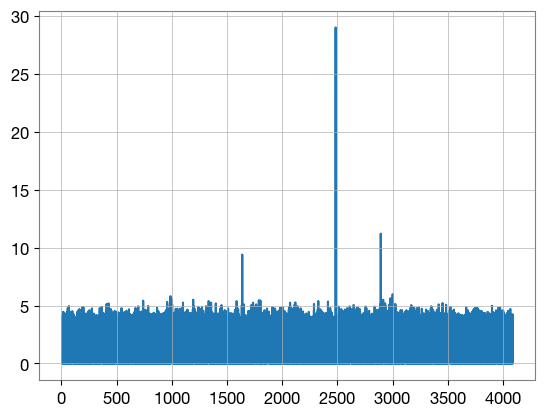

In [21]:
psd = get_psd(data)
template = get_template(10, delta_f=data.delta_f)
template.resize(len(psd))
snr = get_snr(template, data, psd)
plt.plot(snr.sample_times, abs(snr))

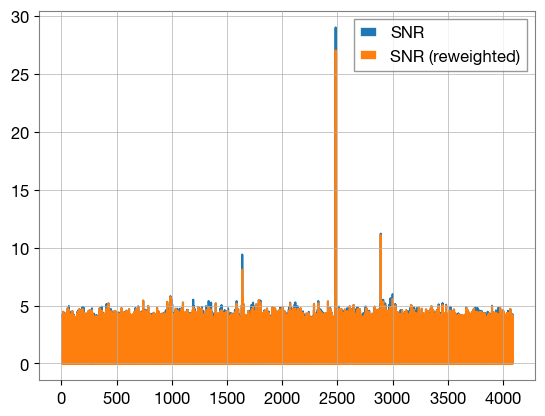

In [23]:
def get_chisq(template, data, psd, nbins=26):
    chisq = power_chisq(template, data, nbins, psd, low_frequency_cutoff=20)
    chisq = chisq.crop(5, 4)
    chisq /= nbins * 2 - 2
    return chisq

chisq = get_chisq(template, data, psd)
nsnr = newsnr(abs(snr), chisq)

plt.plot(snr.sample_times, abs(snr), label="SNR")
plt.plot(snr.sample_times, nsnr, label="SNR (reweighted)")
plt.legend()

In [44]:
get_snr_peak(snr)

(28.983877028389774, 2483.9682617190006)

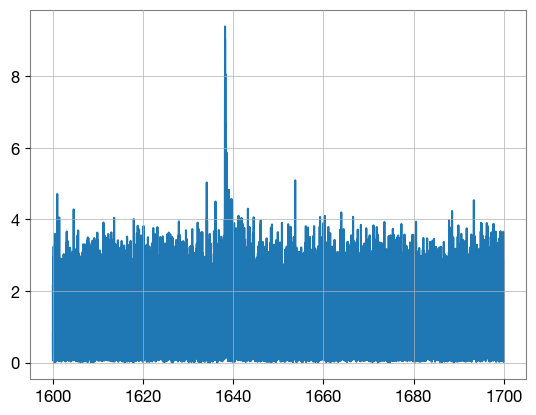

In [30]:
mask = snr.sample_times > 1600
mask &= snr.sample_times < 1700
plt.plot(snr.sample_times[mask], abs(snr.data[mask]), label="SNR")

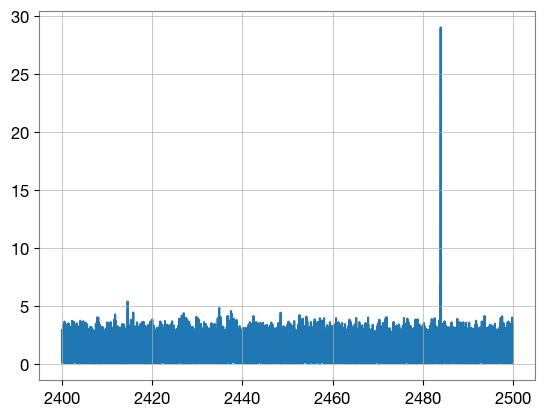

In [31]:
mask = snr.sample_times > 2400
mask &= snr.sample_times < 2500
plt.plot(snr.sample_times[mask], abs(snr.data[mask]), label="SNR")

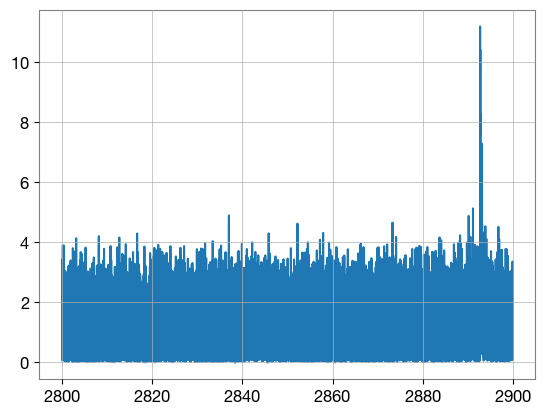

In [34]:
mask = snr.sample_times > 2800
mask &= snr.sample_times < 2900
plt.plot(snr.sample_times[mask], abs(snr.data[mask]), label="SNR")

In [24]:
def plot_q(strain, outseg=None):
    from gwpy.timeseries import TimeSeries
    q = TimeSeries.from_pycbc(strain).q_transform(frange=(30, 500), outseg=outseg)
    fig = q.plot()
    fig.colorbar()
    ax = fig.gca()
    ax.set_yscale('log')
    return fig

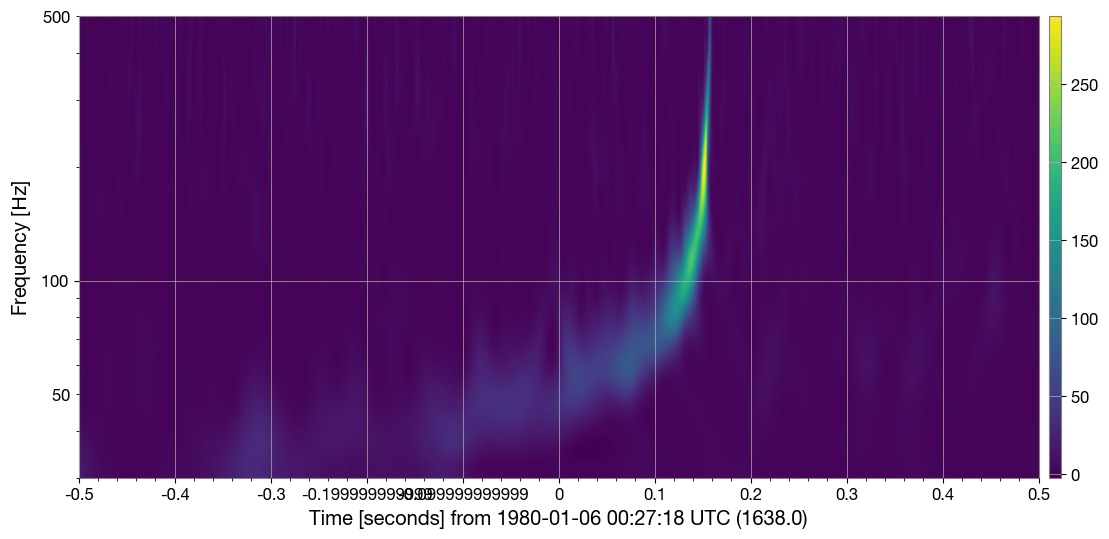

In [42]:
_ = plot_q(data, outseg=(1637.5, 1638.5))

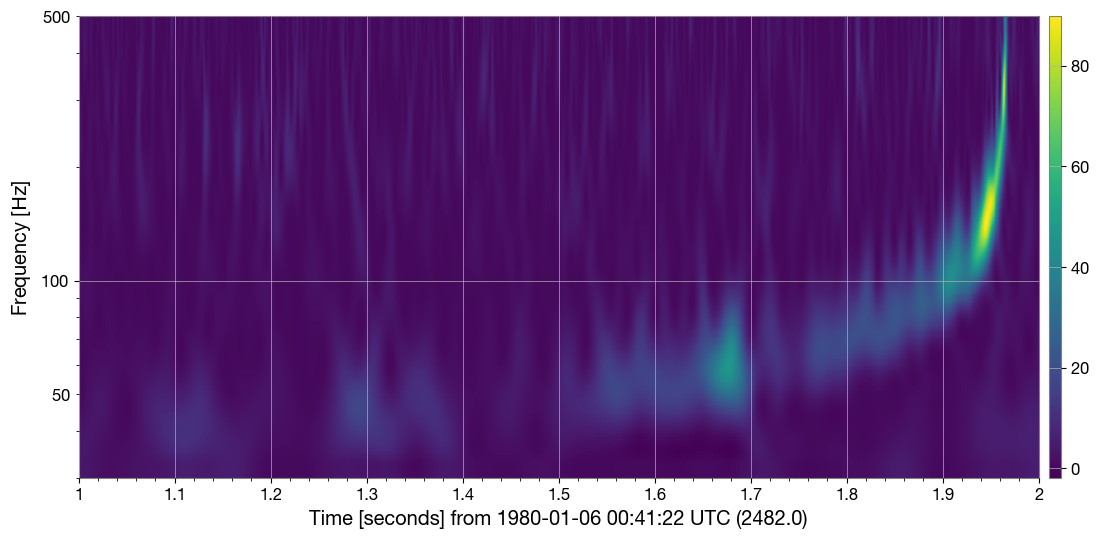

In [43]:
_ = plot_q(data, outseg=(2483, 2484))

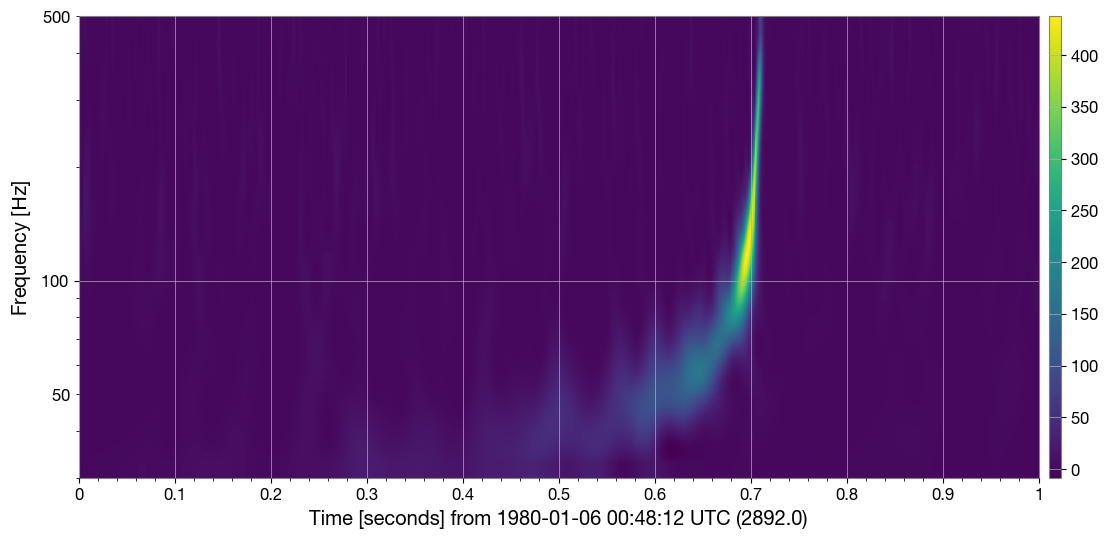

In [41]:
_ = plot_q(data, outseg=(2892, 2893))